In [13]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from tqdm import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of data points
NUM_SAMPLES = 1000

# Kinetic parameters
MU_MAX = 0.870       # 1/h
K_S    = 0.215       # g/l
Y_XS   = 0.496       # g/g
Y_PX   = 0.2         # g/g
S_F    = 1.43 * 200  # g/l

# Initial conditions
X_0 = 5.85
S_0 = 0.013
V_0 = 1.56

# ODE solver parameters
ODE_SOLVER = 'LSODA'

# Time parameters
T_START = 0
T_END = 5
TIME_RANGE = int(T_END - T_START) # Absolute time 

# System dynamics
def system_dynamics(t, y, F) -> np.array:
    X, S, V = y
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (F / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (F / V) * (S_F - S)
    dV_dt = F
    return np.array([dX_dt, dS_dt, dV_dt])

def solve_ode(ode: callable, t_span: list, y0: list, method: str, t_eval: list, args: tuple) -> solve_ivp:
    sol = solve_ivp(ode, t_span=t_span, y0=y0, method=method, args=args, t_eval=t_eval, rtol=1e-6, atol=1e-12)
    # sol.y = np.maximum(sol.y, 0)
    return sol

def plot_solution(sol: solve_ivp) -> None:
    plt.figure(figsize=(12,4))
    plt.plot(sol.t, sol.y[0], label='Biomass')
    plt.plot(sol.t, sol.y[1], label='Substrate')
    plt.xlabel('Time (h)')
    plt.ylabel('Concentration (g/l)')
    plt.legend()
    plt.show()
    

In [14]:
# MPC parameters
dt = 0.1                            # Time step
L = int(TIME_RANGE / dt)            # Number of steps
N_p = 7                             # Prediction horizon
Q = 2.5                             # Weight for tracking
Q_term = 0.0                        # Weight for terminal state
R = 0.01                             # Weight for control effort
OPTIMIZATION_METHOD = 'SLSQP' # Optimization method. Other options: 'SLSQP, 'L-BFGS-B', 'trust-constr', 'COBYLA', 'Powell', 'Nelder-Mead'

# Bounds for feeding rate
F_MIN = 0.0                  # l/h
F_MAX = 0.1                  # l/h
DELTA_F_MAX = 0.05           # Maximum change in feed rate
F_0 = (F_MAX - F_MIN) / 2    # Initial feed rate
BOUNDS = [(F_MIN, F_MAX) for _ in range(N_p)] 

# X_setpoint
X_sp = 30

print(f'Number of steps: {L} and dt: {dt}')

Number of steps: 50 and dt: 0.1


In [15]:
# Load torch model
model_name = "pinc_model_v5.pth"
model_exists = os.path.exists(f'./models/{model_name}')

def numpy_to_tensor(array):
    return torch.tensor(array, requires_grad=True, dtype=torch.float32).to(DEVICE).reshape(-1, 1)

def grad(outputs, inputs):
    return torch.autograd.grad(outputs.sum(), inputs, create_graph=True)[0]

class PINN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.input = nn.Linear(input_dim, 256)
        self.hidden = nn.Linear(256, 256)
        self.output = nn.Linear(256, output_dim)

    def forward(self, x):
        x = torch.tanh(self.input(x))
        x = torch.tanh(self.hidden(x))
        x = torch.tanh(self.hidden(x))
        x = self.output(x)
        return x

if model_exists:
    net = PINN(input_dim=5, output_dim=3).to(DEVICE)
    net.load_state_dict(torch.load(f'./models/{model_name}', weights_only=True))
    net.eval()
else:
    raise FileNotFoundError(f"Model file './models/{model_name}' does not exist.")

In [16]:
def make_pytorch_cost_with_grad(X_init, S_init, V_init, T_s):
    def wrapped(F_numpy):
        F_tensor = torch.nn.Parameter(torch.tensor(F_numpy, dtype=torch.float32, device=DEVICE).reshape(-1, 1))

        X_ts = torch.tensor([[X_init]], dtype=torch.float32, device=DEVICE)
        S_ts = torch.tensor([[S_init]], dtype=torch.float32, device=DEVICE)
        V_ts = torch.tensor([[V_init]], dtype=torch.float32, device=DEVICE)

        J = torch.tensor(0.0, dtype=torch.float32, device=DEVICE)

        for k in range(N_p):
            F_k = F_tensor[k].view(1, 1)
            t_input = torch.tensor([[T_s]], dtype=torch.float32, device=DEVICE)
            input_vec = torch.cat([t_input, X_ts, S_ts, V_ts, F_k], dim=1)
            y_k = net(input_vec)
            X_next, S_next, V_next = y_k[0, 0], y_k[0, 1], y_k[0, 2]
            
            J += (Q * (X_next - X_sp) ** 2).squeeze()
            if k > 0:
                J += (R * (F_tensor[k] - F_tensor[k - 1]) ** 2).squeeze()

            X_ts = X_next.view(1, 1)
            S_ts = S_next.view(1, 1)
            V_ts = V_next.view(1, 1)

        J.backward()

        if F_tensor.grad is None:
            raise RuntimeError("F_tensor.grad is None. Autograd graph might be broken.")

        return J.item(), F_tensor.grad.detach().cpu().numpy().flatten()

    return wrapped


In [17]:
X = np.zeros(L)
S = np.zeros(L)
V = np.zeros(L)
F = np.zeros(L)
X[0], S[0], V[0] = X_0, S_0, V_0

for i in tqdm(range(L - 1)):
    if i == 0:
        F_prev = np.full(N_p, F_0)

    cost_with_grad = make_pytorch_cost_with_grad(X[i], S[i], V[i], dt)

    res = minimize(cost_with_grad,
                   F_prev,
                   method=OPTIMIZATION_METHOD,
                   bounds=BOUNDS,
                   jac=True,
                   options={'maxiter': 30, 'disp': False})

    F_opt = res.x
    F_new = F_opt[0]
    F[i + 1] = F_new
    F_prev = F_opt

    # Now use real dynamics to simulate one step forward
    def ode_step(t, y):  # Wrapper for fixed F
        return system_dynamics(t, y, F_new)

    t_span = [0, dt]
    y0 = [X[i], S[i], V[i]]
    sol_step = solve_ivp(ode_step, t_span=t_span, y0=y0, method=ODE_SOLVER, t_eval=[dt], rtol=1e-6, atol=1e-12)

    # Update state
    X[i + 1] = sol_step.y[0, -1]
    S[i + 1] = sol_step.y[1, -1]
    V[i + 1] = sol_step.y[2, -1]


100%|██████████| 49/49 [00:01<00:00, 30.98it/s]


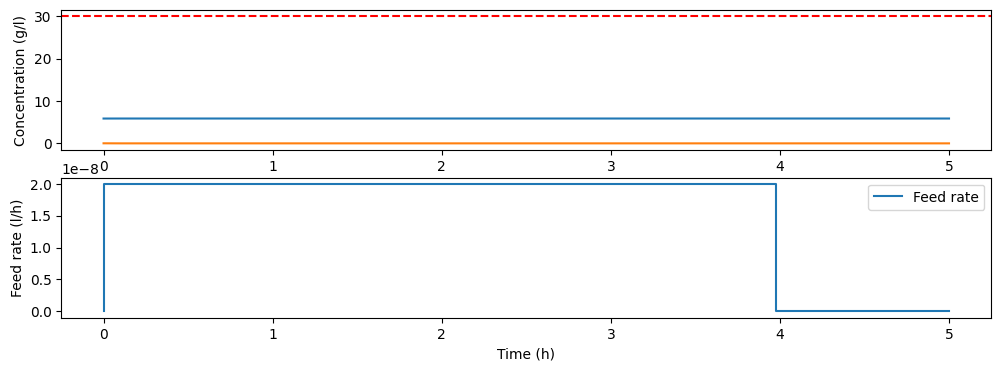

In [18]:
time= np.linspace(T_START, T_END, L)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(time, X, label='Biomass')
plt.plot(time, S, label='Substrate')
plt.axhline(y=X_sp, color='r', linestyle='--', label='Setpoint')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/l)')

plt.subplot(2,1,2)
plt.step(time, F, label='Feed rate')
plt.xlabel('Time (h)')
plt.ylabel('Feed rate (l/h)')
plt.legend()
plt.show()

Evaluate using real system dynamics

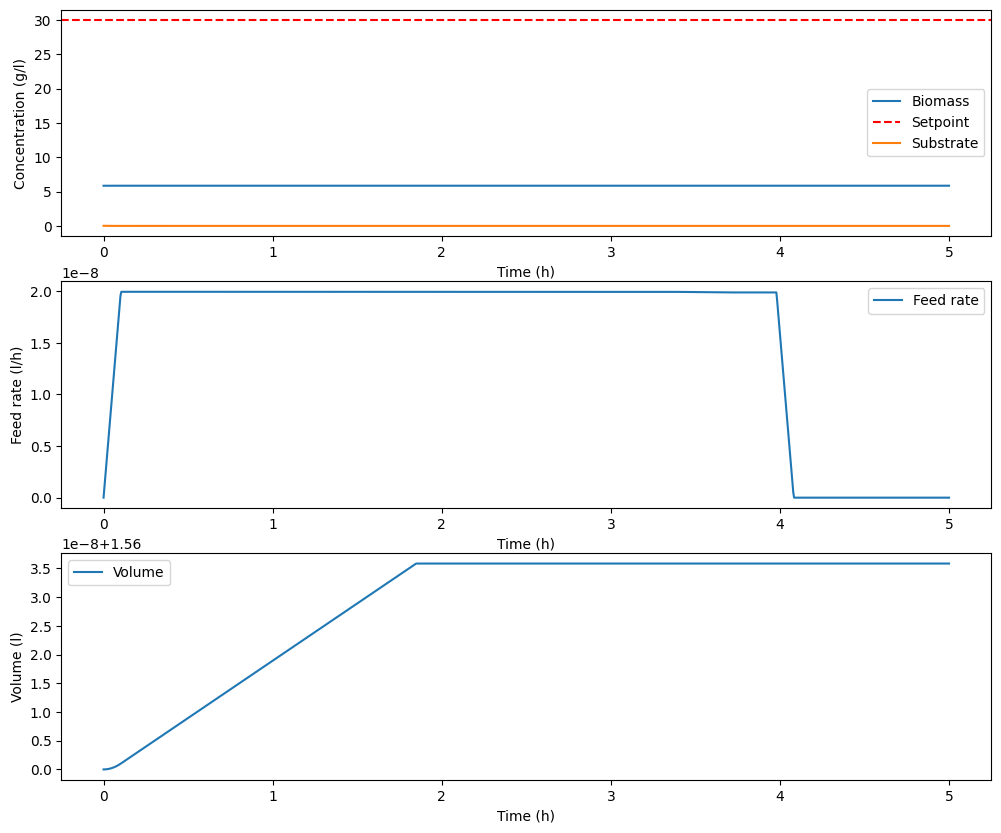

In [19]:
from scipy.interpolate import interp1d

# System dynamics
def simulate(t, y, F_func) -> np.array:
    
    F = F_func(t)   
    
    X, S, V = y
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (F / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (F / V) * (S_F - S)
    dV_dt = F
    return np.array([dX_dt, dS_dt,dV_dt])

F_func = interp1d(time, F, kind='linear', fill_value='extrapolate')
t_eval = np.linspace(T_START, T_END, NUM_SAMPLES)
sol = solve_ivp(simulate, t_span=[T_START, T_END], y0=[X_0, S_0, V_0], method=ODE_SOLVER, t_eval=t_eval, args=(F_func,))

# Plot results
plt.figure(figsize=(12,10))
plt.subplot(3,1,1)
plt.plot(sol.t, sol.y[0], label='Biomass')
plt.axhline(y=X_sp, color='r', linestyle='--', label='Setpoint')
plt.plot(sol.t, sol.y[1], label='Substrate')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/l)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(sol.t, F_func(sol.t), label='Feed rate')
plt.xlabel('Time (h)')
plt.ylabel('Feed rate (l/h)')
plt.legend()

plt.subplot(3,1,3)
plt.plot(sol.t, sol.y[2], label='Volume')
plt.xlabel('Time (h)')
plt.ylabel('Volume (l)')
plt.legend()
plt.show()